<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Shipping_Data_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [36]:
result = pd.read_csv('training_data.csv', parse_dates=['WEEK_START_DATE'])
result['WEEK_START_DATE'] = pd.to_datetime(result['WEEK_START_DATE'], errors='coerce')
result

,SKU,FISCAL_MONTH,WEEK_START_DATE,SHIPPED_QTY,ORDER_QTY,CONFIRMED_ORDER_QTY
0,SKU1101,201501,2015-01-05,3870,0,0
1,SKU1101,201501,2015-01-12,990,0,0
2,SKU1101,201501,2015-01-19,2340,0,0
3,SKU1101,201502,2015-01-26,16830,0,0
4,SKU1101,201502,2015-02-02,810,0,0
...,...,...,...,...,...,...
58075,SKU1340,201907,2019-07-22,270,180,180
58076,SKU1340,201908,2019-07-29,180,180,180
58077,SKU1340,201908,2019-08-05,720,720,720
58078,SKU1340,201908,2019-08-12,1530,2700,2700


In [37]:
df= result.iloc[:,[0,2,3]]
df= df.set_index(['WEEK_START_DATE'])
df

,SKU,SHIPPED_QTY
WEEK_START_DATE,,
2015-01-05,SKU1101,3870
2015-01-12,SKU1101,990
2015-01-19,SKU1101,2340
2015-01-26,SKU1101,16830
2015-02-02,SKU1101,810
...,...,...
2019-07-22,SKU1340,270
2019-07-29,SKU1340,180
2019-08-05,SKU1340,720


In [38]:
sep_data = df.groupby('SKU')
df_sku = sep_data.get_group('SKU1101')
#resampling on bases of month
uni_data = df_sku.resample('M').sum() 
print('\n',uni_data.head())
print('\n',uni_data.shape)


                  SHIPPED_QTY
WEEK_START_DATE             
2015-01-31             24030
2015-02-28             14310
2015-03-31             30060
2015-04-30             13680
2015-05-31             30420

 (56, 1)


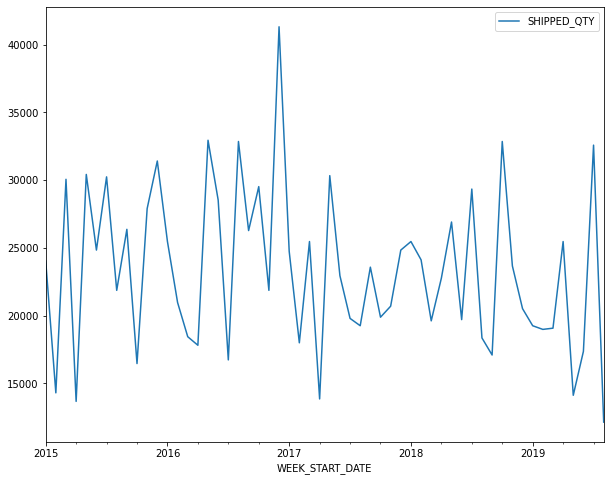

In [39]:
uni_data.plot()

In [0]:
#taking mean and standered deviation
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()
#normalizing the data
uni_data = (uni_data-uni_train_mean)/uni_train_std
#to numpy array
uni_data= uni_data.to_numpy()

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(uni_data, 0, None, univariate_past_history, univariate_future_target)

In [43]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (44, 12, 1)
Y Shape: (44, 1)


In [53]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.1)),
                                   tf.keras.layers.Dropout(0.15),
                                   tf.keras.layers.Dense(1),
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 192)         75264     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 192)         221952    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96)                92544     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 389,857
Trainable params: 389,857
Non-trainable params: 0
__________________________________________________

In [54]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular])

Epoch 1/125
2/2 [==============================] - 0s 125ms/step - loss: 0.9614 - lr: 1.0000e-06
Epoch 2/125
2/2 [==============================] - 0s 121ms/step - loss: 0.9594 - lr: 1.1220e-06
Epoch 3/125
2/2 [==============================] - 0s 125ms/step - loss: 0.9596 - lr: 1.2589e-06
Epoch 4/125
2/2 [==============================] - 0s 127ms/step - loss: 0.9597 - lr: 1.4125e-06
Epoch 5/125
2/2 [==============================] - 0s 131ms/step - loss: 0.9598 - lr: 1.5849e-06
Epoch 6/125
2/2 [==============================] - 0s 170ms/step - loss: 0.9615 - lr: 1.7783e-06
Epoch 7/125
2/2 [==============================] - 0s 170ms/step - loss: 0.9608 - lr: 1.9953e-06
Epoch 8/125
2/2 [==============================] - 0s 139ms/step - loss: 0.9605 - lr: 2.2387e-06
Epoch 9/125
2/2 [==============================] - 0s 124ms/step - loss: 0.9609 - lr: 2.5119e-06
Epoch 10/125
2/2 [==============================] - 0s 155ms/step - loss: 0.9598 - lr: 2.8184e-06
Epoch 11/125
2/2 [===========

In [55]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.004466836
0.9323022961616516


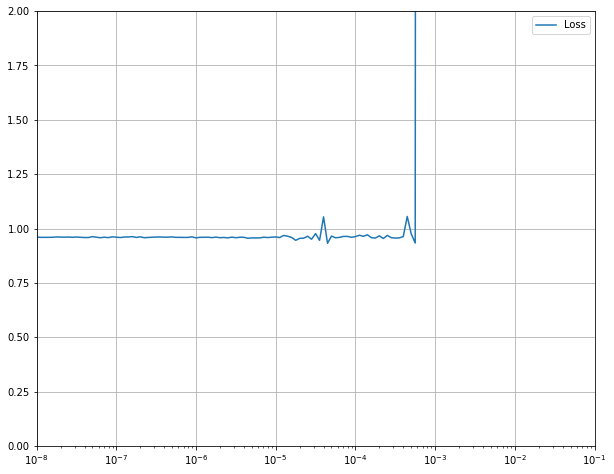

In [56]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.axis([1e-8, 1e-1, 0, 2])
plt.legend(loc='best')
plt.grid(True)

In [57]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                  #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                  #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, activation='relu', dropout=0.25, recurrent_dropout=0.1)),
                                   tf.keras.layers.Dropout(0.15),
                                   tf.keras.layers.Dense(1)
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 96)                19200     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 19,297
Trainable params: 19,297
Non-trainable params: 0
_________________________________________________________________


In [61]:
history= model.fit(x,y, epochs= 800)

Epoch 1/800
2/2 [==============================] - 0s 45ms/step - loss: 0.5497
Epoch 2/800
2/2 [==============================] - 0s 43ms/step - loss: 0.4570
Epoch 3/800
2/2 [==============================] - 0s 43ms/step - loss: 0.4011
Epoch 4/800
2/2 [==============================] - 0s 55ms/step - loss: 0.5013
Epoch 5/800
2/2 [==============================] - 0s 58ms/step - loss: 0.6100
Epoch 6/800
2/2 [==============================] - 0s 45ms/step - loss: 0.4460
Epoch 7/800
2/2 [==============================] - 0s 43ms/step - loss: 0.5032
Epoch 8/800
2/2 [==============================] - 0s 44ms/step - loss: 0.4408
Epoch 9/800
2/2 [==============================] - 0s 49ms/step - loss: 0.5152
Epoch 10/800
2/2 [==============================] - 0s 48ms/step - loss: 0.6241
Epoch 11/800
2/2 [==============================] - 0s 45ms/step - loss: 0.5054
Epoch 12/800
2/2 [==============================] - 0s 41ms/step - loss: 0.5136
Epoch 13/800
2/2 [==============================]

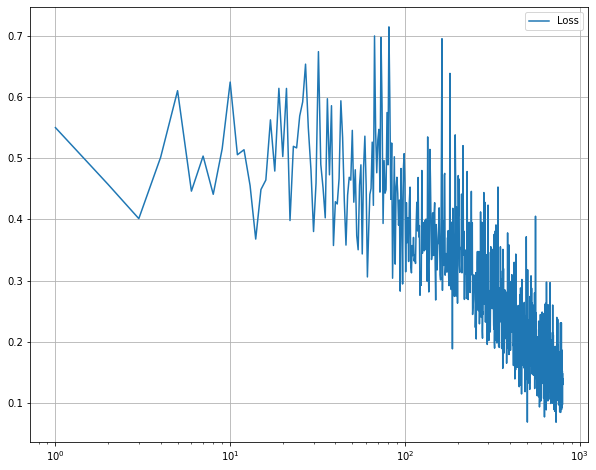

In [62]:
epochs= range(1,801)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(44, 12, 1)
(44, 1)


[]

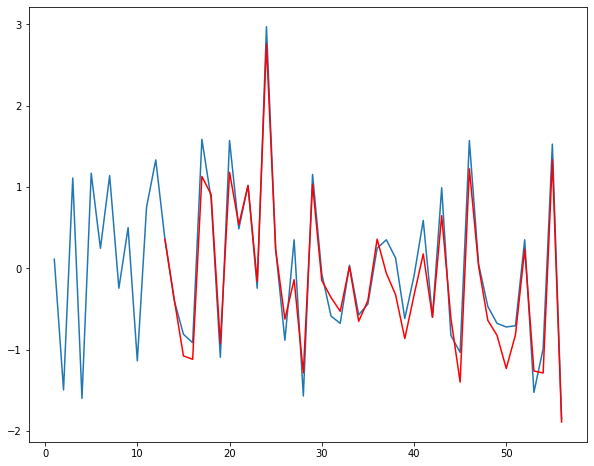

In [63]:
numbers=range(1, 57)
num= range(13,57)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,uni_data)
plt.plot(num,y_pred,'r')
plt.plot()

**Forecasting**

Predict Number 1 SHIPPED_QTY    11924.226749
dtype: float64
Predict Number 2 SHIPPED_QTY    13257.529938
dtype: float64
Predict Number 3 SHIPPED_QTY    37290.013204
dtype: float64
Predict Number 4 SHIPPED_QTY    14348.365211
dtype: float64
Predict Number 5 SHIPPED_QTY    15643.689744
dtype: float64
Predict Number 6 SHIPPED_QTY    25876.288763
dtype: float64
Predict Number 7 SHIPPED_QTY    16558.730983
dtype: float64
Predict Number 8 SHIPPED_QTY    19434.19979
dtype: float64
Predict Number 9 SHIPPED_QTY    21953.580657
dtype: float64
Predict Number 10 SHIPPED_QTY    16439.49761
dtype: float64


[]

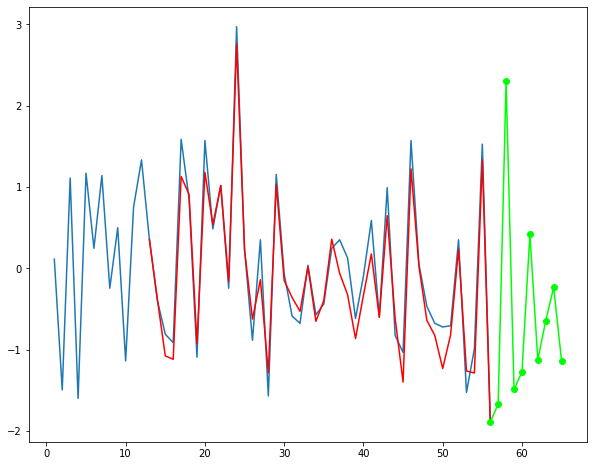

In [68]:
numbers=range(1, 57)
num= range(13,57)
pred= range(56,66)
plot_pred=[]
plt.figure()
y_pred= model.predict(x)
plt.plot(numbers,uni_data)
plt.plot(num,y_pred,'r')
x_new= uni_data[43: len(uni_data)-1]
for i in range(10):
  x_new= x_new.reshape(1,12,1)
  y_new= model.predict(x_new)
  x_new= x_new[0][1:]
  x_new= np.append(x_new, y_new)
  y_new= y_new.reshape(1,)
  real= y_new*uni_train_std+uni_train_mean
  print('Predict Number {}'.format(i+1), real)
  plot_pred.append(y_new)
  

plt.plot(pred, plot_pred, '-ok', color='#00ff00')
plt.plot()

In [0]:
model.save('model.h5')